# Sexism Detection using LLMs

### Contributors
- [Ali Akbar Halvaei](https://github.com/Ali-Akbarhalvaei) 
- [Ali Loloee](https://github.com/aliloloee) 

In [1]:
!pip install transformers
!pip install datasets
!pip install accelerate -U
!pip install evaluate
!pip install bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 32.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
from transformers import BitsAndBytesConfig
import torch
from transformers import AutoModelForCausalLM
from tqdm import tqdm
from sklearn.metrics import f1_score, accuracy_score

#### Availability of GPU

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU instead.")

# Set device globally
torch.set_default_tensor_type(torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor)

Using GPU: Tesla T4


/usr/local/lib/python3.10/dist-packages/torch/__init__.py:1144: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:432.)
  _C._set_default_tensor_type(t)


In [4]:
!nvidia-smi

Mon Jan 13 10:28:01 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8              11W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

#### Clear GPU memory

In [5]:
import gc

model = None
del model
trainer = None
del trainer

with torch.no_grad():
    torch.cuda.empty_cache()

gc.collect()

102

#### HuggingFace login

In [6]:
from huggingface_hub import login

login(token="") # Enter token here

### Data prepration

#### Data loading

In [7]:
import os
DATASET_PATH = 'data/'

The main dataset

In [8]:
df = pd.read_csv(DATASET_PATH + 'a2_test.csv')
df.head(5)

,rewire_id,text,label_sexist
0,sexism2022_english-17133,The boys must be gaming because there goes the...,not sexist
1,sexism2022_english-14197,Look at those eyes. Either someone unexpectedl...,sexist
2,sexism2022_english-3018,Old man mogs everyone in this sub,not sexist
3,sexism2022_english-5301,"Excellent, I was just looking at another post ...",not sexist
4,sexism2022_english-17796,So you run back to daddy whenever you need hel...,sexist


The demonstrations

In [9]:
df2 = pd.read_csv(DATASET_PATH + 'demonstrations.csv')
df2.head()

,rewire_id,text,label_sexist
0,sexism2022_english-10348,I would never have my kid go to a daycare with...,not sexist
1,sexism2022_english-7950,Democrat women are so butt fucking ugly.,sexist
2,sexism2022_english-7742,If you really wanted to twist the knife you’d ...,not sexist
3,sexism2022_english-16170,Those women are pro-rape. They didn’t care abo...,sexist
4,sexism2022_english-9857,Married a bitch... Is it the standard scenario...,sexist


#### Datset

In [10]:
from torch.utils.data import Dataset

class PreTokenizedDataset(Dataset):
    def __init__(self, tokenized_prompts, labels):
        """
        Args:
            tokenized_prompts: A dictionary containing `input_ids` and `attention_mask` as tensors.
            labels: A list or tensor of labels corresponding to the tokenized prompts.
        """
        self.input_ids = tokenized_prompts['input_ids']
        self.attention_mask = tokenized_prompts['attention_mask']
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'labels': self.labels[idx]
        }

def prepare_dataset(tokenized_prompts, labels):
  Binary_labels = labels.map({'sexist': 1, 'not sexist': 0})
  dataset = PreTokenizedDataset(tokenized_prompts, Binary_labels)
  return dataset

#### Error Analysis DataFrame

To facilitate a more comprehensive error analysis in the subsequent steps, we will utilize the `error_analysis_pd` DataFrame. This DataFrame will not only store the metrics *accuracy* and *fail_ratio* but will also include four additional parameters. The first two are: *answers_with_extra_words* and *exact_answers*. These parameters will respectively represent the number of responses that contained words other than "YES" or "NO" and the number of responses that were exactly "YES" or "NO". The second two are: *yes_count* and *no_count*. These parameters will respectively represent the number of "YES"s and "NO"s.


In [11]:
columns = ['accuracy', 'fail_ratio', 'answers_with_extra_words', 'exact_answers', 'yes_count', 'no_count']
error_analysis_pd = pd.DataFrame(columns=columns)

## Implementation of tasks

In this notebook, we picked two models :
1. Microsoft Phi 3.5 mini instruct
2. Mistral V3

In the first section, we implement Phi and in the second section, we implement Mistral V3. The quantization method in this notebook is a 4-
bit quantizatio.


for each model, we try both zero-shot and few-shot prompting.


### 1. Microsoft Phi 3.5 mini instruct

#### Task 1: Model setup

In [12]:
from transformers import BitsAndBytesConfig

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

In [13]:
# Phi3.5 did not need token reservation on HuggingFace
model_card = "microsoft/Phi-3.5-mini-instruct"
tokenizer = AutoTokenizer.from_pretrained(model_card)

# Assign pad_token if not already defined
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

terminators = [
    tokenizer.eos_token_id,
    tokenizer.convert_tokens_to_ids("<|eot_id|>") if "<|eot_id|>" in tokenizer.get_vocab() else None
]
terminators = [t for t in terminators if t is not None]

model = AutoModelForCausalLM.from_pretrained(
    model_card,
    return_dict=True,
    quantization_config=bnb_config,
    device_map='auto'
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/3.98k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/306 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/3.45k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/16.3k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/195 [00:00<?, ?B/s]

In [14]:
generation_config = model.generation_config
generation_config.max_new_tokens = 10
generation_config.eos_token_id = tokenizer.eos_token_id
generation_config.pad_token_id = tokenizer.eos_token_id
generation_config.temperature = None
generation_config.num_return_sequences = 1

#### Task 2: Prompt setup

In [15]:
prompt = [
    {
        'role': 'system',
        'content': 'You are an annotator for sexism detection.'
    },
    {
        'role': 'user',
        'content': """Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        TEXT:
        {text}

        ANSWER:
        """
    }
]

prompt = tokenizer.apply_chat_template(prompt, tokenize=False, add_generation_prompt=True)

In [16]:
print(prompt)

<|system|>
You are an annotator for sexism detection.<|end|>
<|user|>
Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        TEXT:
        {text}

        ANSWER:
        <|end|>
<|assistant|>



In [17]:
def prepare_prompts(texts, prompt_template, tokenizer):

    formatted_prompts = [prompt_template.format(text=text) for text in texts]
    tokenized_prompts = tokenizer.batch_encode_plus(
        formatted_prompts,
        return_tensors='pt',
        padding=True,
        truncation=True
    )
    return tokenized_prompts

In [18]:
tokenized_prompts = prepare_prompts(df['text'], prompt, tokenizer)
tokenized_prompts

{'input_ids': tensor([[32000, 32000, 32000,  ...,   308, 32007, 32001],
        [32000, 32000, 32000,  ...,   308, 32007, 32001],
        [32000, 32000, 32000,  ...,   308, 32007, 32001],
        ...,
        [32000, 32000, 32000,  ...,   308, 32007, 32001],
        [32000, 32000, 32000,  ...,   308, 32007, 32001],
        [32000, 32000, 32000,  ...,   308, 32007, 32001]]), 'attention_mask': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1]])}

#### Task 3: Inference

In [19]:
def detect_failure(response):

    """
    Detects whether the response contains a valid answer ('YES' or 'NO') after the keyword 'ANSWER:'.

    The function checks the given response for the presence of the keyword 'ANSWER:'.
    If found, it extracts the text following 'ANSWER:' and checks whether the first word
    in that text is either 'YES' or 'NO'. If not, or if 'ANSWER:' is not
    present in the response, the function considers it a failure and returns True.

    Args:
        response (str): The text response to analyze.

    Returns:
        bool:
            - True if 'ANSWER:' is not present in the response or the first word after it
              is neither 'YES' nor 'NO'.
            - False otherwise.
    """
    answer_index = response.find("ANSWER:")

    if answer_index != -1:
        # Extract the text after 'ANSWER:'
        answer_section = response[answer_index + len("ANSWER:"):].strip()
        # Get the first word from the answer section
        words = answer_section.split()
        first_word = words[0].upper() if words else ""  # Get the first word, if it exists

        if first_word not in {"YES", "NO"}:
            return True

    else:
        return True

    return False

def process_response(response):
    """
    Processes a response and converts the first word after 'ANSWER:'
    to 1 (for 'YES') or 0 (for 'NO' or any other value).

    Args:
        raw response generated by our LLM

    Returns:
        A binary value,
    """
    answer_index = response.find("ANSWER:")
    if answer_index != -1:
        answer_section = response[answer_index + len("ANSWER:"):].strip()
        words = answer_section.split()
        first_word = words[0].upper() if words else ""

        if first_word not in {"YES", "NO"}:
            return 0

        if first_word == "YES":
            return 1

        else:
            return 0
    else:
        return 0

def generate_responses(model, prompt_examples):
    """
    This function implements the inference loop for a LLM model.
    Given a set of examples, the model is tasked to generate a response.

    Inputs:
      model: LLM model instance for prompting
      prompt_examples: pre-processed text samples

    Outputs:
      generated responses
    """
    raw_responses = []
    predictions = []

    for batch in tqdm(prompt_examples, desc="Generating responses"):
        input_ids = batch['input_ids'].to(model.device)
        attention_mask = batch['attention_mask'].to(model.device)
        labels = batch.get('labels')
        labels = labels.to(model.device) if labels is not None else None

        response = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            generation_config=generation_config,
            do_sample=False,
            use_cache=True
        )

        raw_response = tokenizer.batch_decode(response, skip_special_tokens=True)
        raw_responses.extend(raw_response)

    return raw_responses

In [20]:
from torch.utils.data import DataLoader

dataset = prepare_dataset(tokenized_prompts, df['label_sexist'])
data_loader = DataLoader(dataset, batch_size=1, shuffle=False)
raw_responses = generate_responses(model, data_loader)

Generating responses: 100%|██████████| 300/300 [06:14<00:00,  1.25s/it]


#### Task 4: Metrics

In [21]:
def compute_metrics(responses, y_true):
    """
    Computes accuracy and fail-ratio metrics for LLM responses.

    Args:
        responses (list of int): Binary predictions from LLM (1 for YES, 0 for NO or invalid responses).
        y_true (list of int): Ground-truth binary labels.

    Returns:
        dict: Dictionary containing 'accuracy' and 'fail_ratio'.
    """
    assert len(responses) == len(y_true)

    predictions = []
    fail_count = 0

    for resp in responses:
        if detect_failure(resp):
            fail_count += 1
        y_pred = process_response(resp)
        predictions.append(y_pred)

    acc = accuracy_score(y_pred=predictions, y_true=y_true)
    fail_ratio = fail_count / len(responses)


    return {
        "accuracy": acc,
        "fail_ratio": fail_ratio
    }


In [22]:
y_true = df['label_sexist'].map({'sexist': 1, 'not sexist': 0})
result = compute_metrics(raw_responses, y_true)

In [23]:
result

{'accuracy': 0.59, 'fail_ratio': 0.0}

##### Update `error_analysis_pd`

In [24]:
def words_check(responses, model_card):
    """
    Analyzes a list of responses to count occurrences of extra words and categorize them
    based on the first word being "YES" or "NO".

    This function processes a list of responses generated by a model to detect if there
    are additional words following the first "YES" or "NO" in each response. It counts:
    - The total number of responses with extra words after "YES" or "NO".
    - The number of such responses where the first word is "YES".
    - The number of such responses where the first word is "NO".

    Args:
        responses (list of str): A list of text responses to analyze.
        model_card (str): The name or identifier of the model card used for generating the responses.

    Returns:
        tuple:
            - extra_words_count (int): The total number of responses containing extra words
              after "YES" or "NO".
            - yes_words_count (int): The number of responses starting with "YES" that also
              contain extra words.
            - no_words_count (int): The number of responses starting with "NO" that also
              contain extra words.
    """
    extra_words_count = 0
    yes_words_count = 0
    no_words_count = 0

    for response in responses:
        answer_index = response.rfind("ANSWER:")
        if answer_index != -1:
            answer_section = response[answer_index + len("ANSWER:"):].strip()
            words = answer_section.split()
            first_word = words[0].upper() if words else ""

            # Count if there are more words after 'YES' or 'NO'
            if first_word in {"YES", "NO"} and len(words) > 1:
                extra_words_count += 1

            if first_word == "YES":
                yes_words_count += 1
            elif first_word == "NO":
                no_words_count += 1

    return extra_words_count, yes_words_count, no_words_count

In [25]:
extra_words_count, yes_words_count, no_words_count = words_check(raw_responses, model_card)

In [26]:
data = {
    'accuracy': result['accuracy'],
    'fail_ratio': result['fail_ratio'],
    'answers_with_extra_words': extra_words_count,
    'exact_answers': len(raw_responses) - extra_words_count,
    'yes_count': yes_words_count,
    'no_count': no_words_count
}

error_analysis_pd.loc['Phi_Mini_zeroShot'] = data
error_analysis_pd

,accuracy,fail_ratio,answers_with_extra_words,exact_answers,yes_count,no_count
Phi_Mini_zeroShot,0.59,0.0,234,66,267,33


#### Task 5: Few-shot Inference

In [27]:
def build_few_shot_demonstrations(demonstrations, num_per_class=2):
    """
    Builds few-shot demonstrations for the sexism detection task.

    Args:
        demonstrations: pandas.DataFrame with columns ['text', 'label_sexist'].
        num_per_class: Number of demonstrations to sample per class (default: 2).

    Returns:
        A list of tuples where each tuple is (text, label).
    """
    # Split the demonstrations by class
    sexist_examples = demonstrations[demonstrations['label_sexist'] == 'sexist']
    non_sexist_examples = demonstrations[demonstrations['label_sexist'] == 'not sexist']

    # Randomly sample examples from each class
    sampled_sexist = sexist_examples.sample(n=min(num_per_class, len(sexist_examples))).to_dict('records')
    sampled_non_sexist = non_sexist_examples.sample(n=min(num_per_class, len(non_sexist_examples))).to_dict('records')

    # Format examples as tuples (text, label)
    formatted_examples = []
    for example in sampled_sexist:
        formatted_examples.append((example['text'], 'YES'))
    for example in sampled_non_sexist:
        formatted_examples.append((example['text'], 'NO'))

    return formatted_examples

In [28]:
demonstrations = build_few_shot_demonstrations(df2)
demonstrations = '\n'.join([f'TEXT: {text}\nANSWER: {label}' for (text, label) in demonstrations])

In [29]:
fewShot_prompt_template = [
    {
        'role': 'system',
        'content': 'You are an annotator for sexism detection.'
    },
    {
        'role': 'user',
        'content': """Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        EXAMPLES:
        {examples}

        TEXT:
        {text}

        ANSWER:
        """
    }
]

fewShot_prompt_template = tokenizer.apply_chat_template(fewShot_prompt_template, tokenize=False, add_generation_prompt=True)

In [30]:
def prepare_fewShot_prompts(df, prompt_template, tokenizer, demonstrations):
    """
    This function formats input text samples from a dataset into instruction prompts.

    Inputs:
        dataset: A dataset containing 'text' and 'label_sexist' columns
        prompt_template: The prompt template provided in this assignment
        tokenizer: The transformers Tokenizer object instance associated with the chosen model card

    Outputs:
        formatted_prompts: List of input texts in the form of instruction prompts
        labels: List of corresponding labels (unchanged)
    """
    df['label_sexist'] = df['label_sexist'].astype('str')
    df.loc[:, 'text'] = df['text'].apply(lambda x: prompt_template.format(text=x, examples = demonstrations))
    df['label_sexist'] = df['label_sexist'].map({'sexist': 1, 'not sexist': 0})

    tokenized_prompts = tokenizer.batch_encode_plus(
        df['text'].tolist(),
        return_tensors='pt',
        padding=True,
        truncation=True
    )

    return df, tokenized_prompts

In [31]:
fewShot_formatted_ds, tokenized_fewShot_prompts = prepare_fewShot_prompts(df2, fewShot_prompt_template, tokenizer, demonstrations)

In [32]:
fewShot_formatted_ds = fewShot_formatted_ds[['text', 'label_sexist']]
fewShot_formatted_ds.head(5)

,text,label_sexist
0,<|system|>\nYou are an annotator for sexism de...,0
1,<|system|>\nYou are an annotator for sexism de...,1
2,<|system|>\nYou are an annotator for sexism de...,0
3,<|system|>\nYou are an annotator for sexism de...,1
4,<|system|>\nYou are an annotator for sexism de...,1


In [33]:
fewShot_formatted_ds.iloc[0]['text']

"<|system|>\nYou are an annotator for sexism detection.<|end|>\n<|user|>\nYour task is to classify input text as containing sexism or not. Respond only YES or NO.\n\n        EXAMPLES:\n        TEXT: [USER] I've read that Obama has purged a lot of the generals, maybe those were the right leaning types...plus now the various branches are full of trannies and women, so there's that...\nANSWER: YES\nTEXT: whining pussies >sparklyteenvampire\nANSWER: YES\nTEXT: Are these fucktards mansplaining women’s bodies to us hahah\nANSWER: NO\nTEXT: Did all the Anglo-Saxon men in the mother country die out? Why will they not defend their country?\nANSWER: NO\n\n        TEXT:\n        I would never have my kid go to a daycare with a nog working there. But I also would keep it to myself. Also that font she used should be considered a hate crime\n\n        ANSWER:\n        <|end|>\n<|assistant|>\n"

In [34]:
fewShot_labels = fewShot_formatted_ds['label_sexist'].tolist()
fewShot_ground_truth = fewShot_labels.copy()

fewShot_dataset = PreTokenizedDataset(tokenized_fewShot_prompts, fewShot_labels)
fewShot_data_loader = DataLoader(fewShot_dataset, batch_size=1, shuffle=False)

In [35]:
fewSHot_raw_responses = generate_responses(model ,fewShot_data_loader)
result = compute_metrics(fewSHot_raw_responses, fewShot_ground_truth)
result

Generating responses: 100%|██████████| 1000/1000 [22:25<00:00,  1.35s/it]


{'accuracy': 0.5, 'fail_ratio': 0.0}

##### Update `error_analysis_pd`

In [36]:
extra_words_count, yes_words_count, no_words_count = words_check(fewSHot_raw_responses, model_card)
data = {
    'accuracy': result['accuracy'],
    'fail_ratio': result['fail_ratio'],
    'answers_with_extra_words': extra_words_count,
    'exact_answers': len(fewSHot_raw_responses) - extra_words_count,
    'yes_count': yes_words_count,
    'no_count': no_words_count
}

error_analysis_pd.loc['Phi_Mini_fewShot'] = data
error_analysis_pd

,accuracy,fail_ratio,answers_with_extra_words,exact_answers,yes_count,no_count
Phi_Mini_zeroShot,0.59,0.0,234,66,267,33
Phi_Mini_fewShot,0.50,0.0,30,970,654,346


### 2. Mistral V3

Load data one more time, in case the related dataframes were modified in previous tasks

In [37]:
df = pd.read_csv(DATASET_PATH + 'a2_test.csv')
df2 = pd.read_csv(DATASET_PATH + 'demonstrations.csv')

#### Task 1: Model setup

In [38]:
model_card = 'mistralai/Mistral-7B-Instruct-v0.3'
tokenizer = AutoTokenizer.from_pretrained(model_card)

# Assign pad_token if not already defined
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

terminators = [
    tokenizer.eos_token_id,
    tokenizer.convert_tokens_to_ids("<|eot_id|>") if "<|eot_id|>" in tokenizer.get_vocab() else None
]
terminators = [t for t in terminators if t is not None]

model = AutoModelForCausalLM.from_pretrained(
    model_card,
    return_dict=True,
    quantization_config=bnb_config,
    device_map='auto'
)

tokenizer_config.json:   0%|          | 0.00/141k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/587k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/601 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.55G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

In [39]:
generation_config = model.generation_config
generation_config.max_new_tokens = 10
generation_config.eos_token_id = tokenizer.eos_token_id
generation_config.pad_token_id = tokenizer.eos_token_id
generation_config.temperature = None
generation_config.num_return_sequences = 1

#### Task 2: Prompt setup

In [40]:
prompt = [
    {
        'role': 'system',
        'content': 'You are an annotator for sexism detection.'
    },
    {
        'role': 'user',
        'content': """Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        TEXT:
        {text}

        ANSWER:
        """
    }
]

prompt = tokenizer.apply_chat_template(prompt, tokenize=False, add_generation_prompt=True)

In [41]:
print(prompt)

<s>[INST] You are an annotator for sexism detection.

Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        TEXT:
        {text}

        ANSWER:
        [/INST]


In [42]:
tokenized_prompts = prepare_prompts(df['text'], prompt, tokenizer)
tokenized_prompts

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


{'input_ids': tensor([[   2,    2,    2,  ...,  781, 1041,    4],
        [   2,    2,    2,  ...,  781, 1041,    4],
        [   2,    2,    2,  ...,  781, 1041,    4],
        ...,
        [   2,    2,    2,  ...,  781, 1041,    4],
        [   2,    2,    2,  ...,  781, 1041,    4],
        [   2,    2,    2,  ...,  781, 1041,    4]]), 'attention_mask': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1]])}

#### Task 3: Inference

In [43]:
dataset = prepare_dataset(tokenized_prompts, df['label_sexist'])
data_loader = DataLoader(dataset, batch_size=1, shuffle=False)
raw_responses = generate_responses(model, data_loader)

Generating responses: 100%|██████████| 300/300 [08:00<00:00,  1.60s/it]


#### Task 4: Metrics

In [44]:
y_true = df['label_sexist'].map({'sexist': 1, 'not sexist': 0})
result = compute_metrics(raw_responses, y_true)
result

{'accuracy': 0.59, 'fail_ratio': 0.0}

##### Update `error_analysis_pd`

In [45]:
extra_words_count, yes_words_count, no_words_count = words_check(raw_responses, model_card)

In [46]:
data = {
    'accuracy': result['accuracy'],
    'fail_ratio': result['fail_ratio'],
    'answers_with_extra_words': extra_words_count,
    'exact_answers': len(raw_responses) - extra_words_count,
    'yes_count': yes_words_count,
    'no_count': no_words_count
}

error_analysis_pd.loc['MisteralV3_zeroShot'] = data
error_analysis_pd

,accuracy,fail_ratio,answers_with_extra_words,exact_answers,yes_count,no_count
Phi_Mini_zeroShot,0.59,0.0,234,66,267,33
Phi_Mini_fewShot,0.50,0.0,30,970,654,346
MisteralV3_zeroShot,0.59,0.0,4,296,267,33


#### Task 5: Few-shot Inference

In [47]:
demonstrations = build_few_shot_demonstrations(df2)
demonstrations = '\n'.join([f'TEXT: {text}\nANSWER: {label}' for (text, label) in demonstrations])

In [48]:
fewShot_prompt_template = [
    {
        'role': 'system',
        'content': 'You are an annotator for sexism detection.'
    },
    {
        'role': 'user',
        'content': """Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        EXAMPLES:
        {examples}

        TEXT:
        {text}

        ANSWER:
        """
    }
]

fewShot_prompt_template = tokenizer.apply_chat_template(fewShot_prompt_template, tokenize=False, add_generation_prompt=True)

In [49]:
fewShot_formatted_ds, tokenized_fewShot_prompts = prepare_fewShot_prompts(df2, fewShot_prompt_template, tokenizer, demonstrations)

In [50]:
fewShot_formatted_ds = fewShot_formatted_ds[['text', 'label_sexist']]
fewShot_formatted_ds.head(5)

,text,label_sexist
0,<s>[INST] You are an annotator for sexism dete...,0
1,<s>[INST] You are an annotator for sexism dete...,1
2,<s>[INST] You are an annotator for sexism dete...,0
3,<s>[INST] You are an annotator for sexism dete...,1
4,<s>[INST] You are an annotator for sexism dete...,1


In [51]:
fewShot_formatted_ds.iloc[0]['text']

'<s>[INST] You are an annotator for sexism detection.\n\nYour task is to classify input text as containing sexism or not. Respond only YES or NO.\n\n        EXAMPLES:\n        TEXT: The headline probably has more to do with "white feminazi still trying to find something desperate enough to shag her."\nANSWER: YES\nTEXT: Democrat women are so butt fucking ugly.\nANSWER: YES\nTEXT: FUck i love this PUA red pill alpha all the same superior men being beautiful beta cucks doing everything to please and get women.....\nANSWER: NO\nTEXT: They’ll protect her at all costs. Not because she’s a zipperhead per se, but because she’s, well, not white.\nANSWER: NO\n\n        TEXT:\n        I would never have my kid go to a daycare with a nog working there. But I also would keep it to myself. Also that font she used should be considered a hate crime\n\n        ANSWER:\n        [/INST]'

In [52]:
fewShot_labels = fewShot_formatted_ds['label_sexist'].tolist()
fewShot_ground_truth = fewShot_labels.copy()

fewShot_dataset = PreTokenizedDataset(tokenized_fewShot_prompts, fewShot_labels)
fewShot_data_loader = DataLoader(fewShot_dataset, batch_size=1, shuffle=False)

In [53]:
fewSHot_raw_responses = generate_responses(model ,fewShot_data_loader)
result = compute_metrics(fewSHot_raw_responses, fewShot_ground_truth)
result

Generating responses: 100%|██████████| 1000/1000 [41:45<00:00,  2.51s/it]


{'accuracy': 0.5, 'fail_ratio': 0.0}

##### Update `error_analysis_pd`

In [54]:
extra_words_count, yes_words_count, no_words_count = words_check(fewSHot_raw_responses, model_card)
data = {
    'accuracy': result['accuracy'],
    'fail_ratio': result['fail_ratio'],
    'answers_with_extra_words': extra_words_count,
    'exact_answers': len(fewSHot_raw_responses) - extra_words_count,
    'yes_count': yes_words_count,
    'no_count': no_words_count
}

error_analysis_pd.loc['MisteralV3_fewShot'] = data
error_analysis_pd

,accuracy,fail_ratio,answers_with_extra_words,exact_answers,yes_count,no_count
Phi_Mini_zeroShot,0.59,0.0,234,66,267,33
Phi_Mini_fewShot,0.50,0.0,30,970,654,346
MisteralV3_zeroShot,0.59,0.0,4,296,267,33
MisteralV3_fewShot,0.50,0.0,181,819,671,329


### Task 6: Error Analysis (for both models)

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

#### Confusion Matrix
Given out data, the confusion matrix for each model could be simplified as follows:

TP = yes_count
TN = no_count
FP and FN = 0 (due to fail_ratio being 0.0)

In [56]:
def compute_confusion_matrix(row):
    TP = int(row['yes_count'])
    TN = int(row['no_count'])
    FP = 0  # Derived from fail_ratio = 0.0
    FN = 0  # Derived from fail_ratio = 0.0
    return pd.Series({'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN})

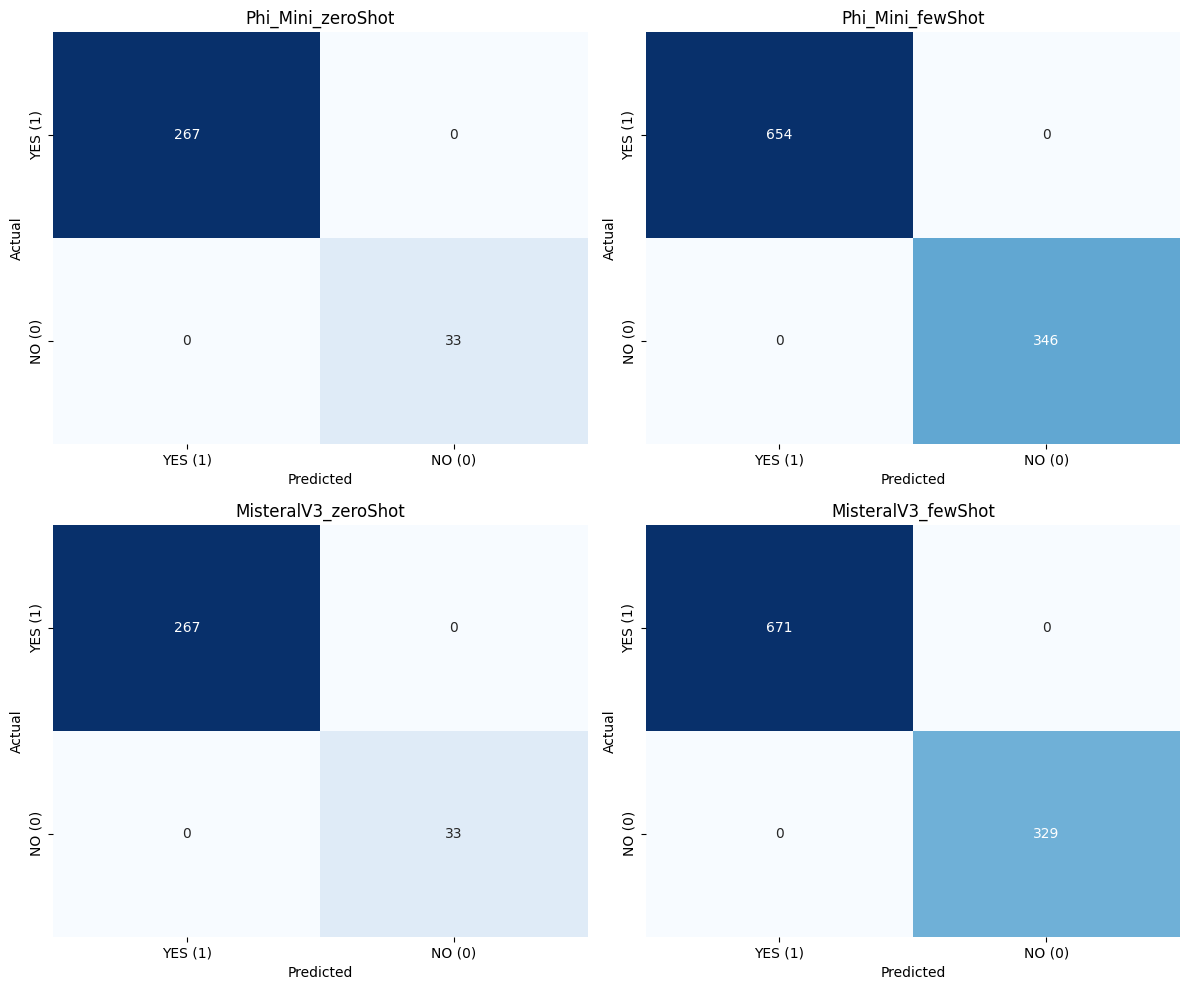

In [57]:
confusion_matrices = error_analysis_pd.apply(compute_confusion_matrix, axis=1)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx, (model_name, row) in enumerate(confusion_matrices.iterrows()):
    cm = [[row['TP'], row['FP']], [row['FN'], row['TN']]]

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx], cbar=False)
    axes[idx].set_title(model_name)
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')
    axes[idx].set_xticklabels(['YES (1)', 'NO (0)'])
    axes[idx].set_yticklabels(['YES (1)', 'NO (0)'])

plt.tight_layout()
plt.show()

#### Accuracy

In [58]:
# Classification Performance Gap
print("=== Classification Performance Gap ===")
print(error_analysis_pd[['accuracy']])
print("\nModel with highest accuracy:")
print(error_analysis_pd[error_analysis_pd['accuracy'] == error_analysis_pd['accuracy'].max()])

=== Classification Performance Gap ===
                     accuracy
Phi_Mini_zeroShot        0.59
Phi_Mini_fewShot         0.50
MisteralV3_zeroShot      0.59
MisteralV3_fewShot       0.50

Model with highest accuracy:
                     accuracy  fail_ratio  answers_with_extra_words  \
Phi_Mini_zeroShot        0.59         0.0                       234   
MisteralV3_zeroShot      0.59         0.0                         4   

                     exact_answers  yes_count  no_count  
Phi_Mini_zeroShot               66        267        33  
MisteralV3_zeroShot            296        267        33  


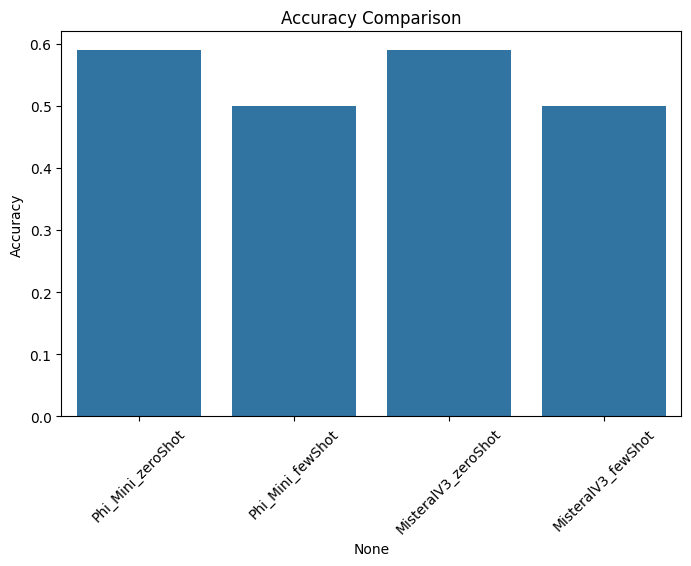

In [59]:
# Plotting Accuracy Comparison
plt.figure(figsize=(8, 5))
sns.barplot(x=error_analysis_pd.index, y=error_analysis_pd['accuracy'])
plt.title('Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.show()

#### Generation Quality

In [60]:
print("\n=== Generation Quality ===")
print(error_analysis_pd[['answers_with_extra_words', 'yes_count', 'no_count']])


=== Generation Quality ===
                     answers_with_extra_words  yes_count  no_count
Phi_Mini_zeroShot                         234        267        33
Phi_Mini_fewShot                           30        654       346
MisteralV3_zeroShot                         4        267        33
MisteralV3_fewShot                        181        671       329


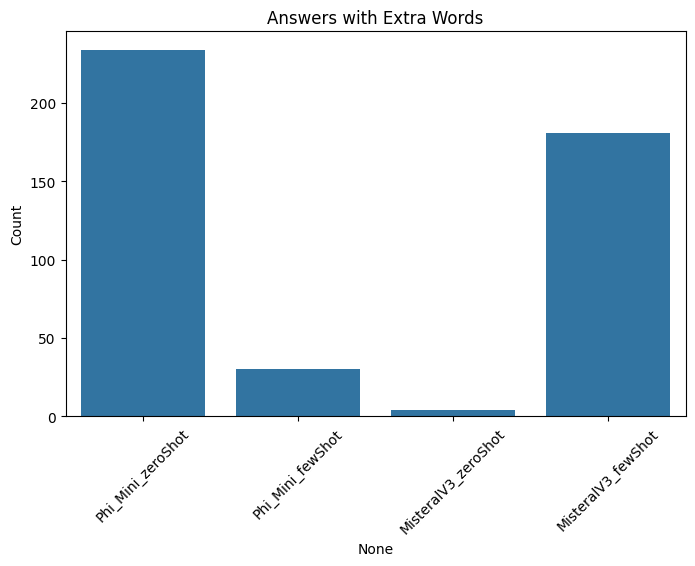

In [61]:
# Plotting Answers with Extra Words
plt.figure(figsize=(8, 5))
sns.barplot(x=error_analysis_pd.index, y=error_analysis_pd['answers_with_extra_words'])
plt.title('Answers with Extra Words')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

<Figure size 1000x600 with 0 Axes>

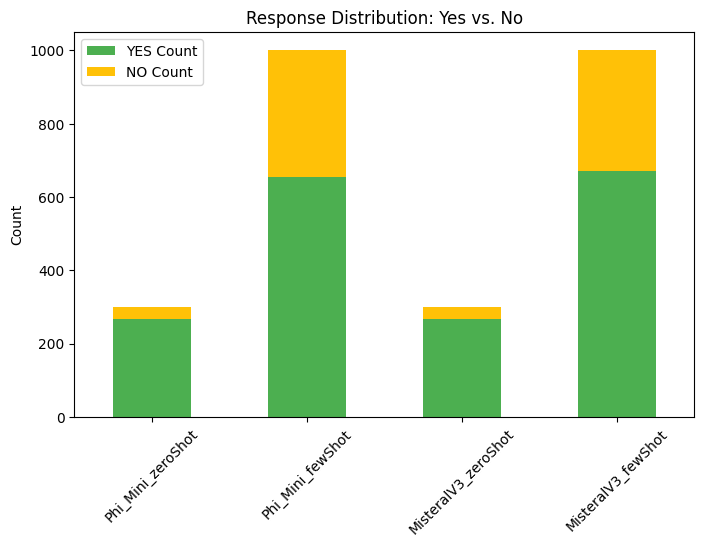

In [62]:
# Errors: Distribution of Yes and No
plt.figure(figsize=(10, 6))
error_analysis_pd[['yes_count', 'no_count']].plot(kind='bar', stacked=True, figsize=(8, 5), color=['#4CAF50', '#FFC107'])
plt.title('Response Distribution: Yes vs. No')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(["YES Count", "NO Count"])
plt.show()

#### Error

In [63]:
# Error Insights
print("\n=== Error Insights ===")
error_analysis_pd['error_ratio'] = error_analysis_pd['answers_with_extra_words'] / (error_analysis_pd['answers_with_extra_words'] + error_analysis_pd['exact_answers'])
print(error_analysis_pd[['answers_with_extra_words', 'exact_answers', 'error_ratio']])


=== Error Insights ===
                     answers_with_extra_words  exact_answers  error_ratio
Phi_Mini_zeroShot                         234             66     0.780000
Phi_Mini_fewShot                           30            970     0.030000
MisteralV3_zeroShot                         4            296     0.013333
MisteralV3_fewShot                        181            819     0.181000


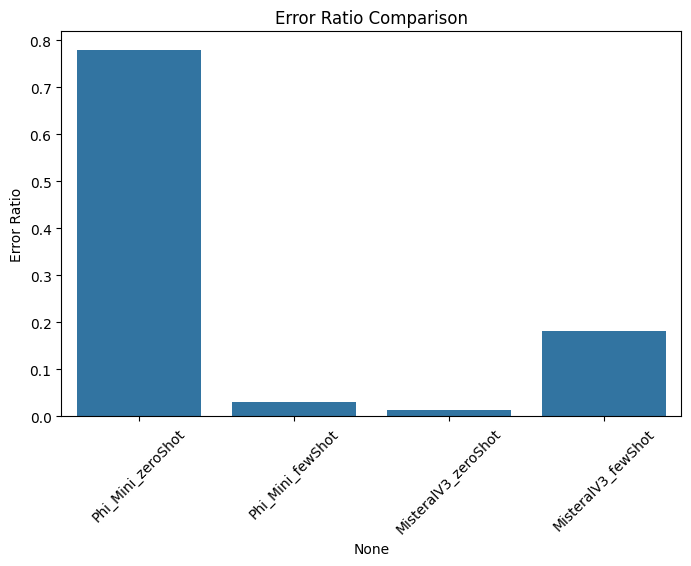

In [64]:
# Plotting Error Ratios
plt.figure(figsize=(8, 5))
sns.barplot(x=error_analysis_pd.index, y=error_analysis_pd['error_ratio'])
plt.title('Error Ratio Comparison')
plt.ylabel('Error Ratio')
plt.xticks(rotation=45)
plt.show()

Since the `fail_ratio` column in the DataFrame is always 0, it doesn't contribute meaningful insights for the analysis. This suggests that no outright failures were recorded in the classification task.

Therefore, the focus should shift to other metrics that provide better insights, such as:

**Accuracy**: How well the models are performing in classifying responses as "YES" or "NO."

**Answers with Extra Words**: Indicates issues with generation quality, where models include unnecessary text.

**Yes/No Counts**: Helps analyze response distribution and any potential bias in the models' outputs.

**Error Ratio**: Derived from answers_with_extra_words and exact_answers, it provides a clearer understanding of response quality issues.